In this last part of the dissertation, we will price an Interest rate swap (IRS), a CDS, CVA and Credit Insurance in Python.

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math
import unittest

First, we start by writing a code to find the present value of an Interest rate swap.

By defintion, an IRS is an agreement between two parties to exchange future interest rate payments of a set period of time. In this case we will consider Vanilla IRS which involves exchange of a fixed rate for a floating rate or viceversa.

In order to find the present value of an IRS, we start with a set of data $years1$ which is a set of matuirties and $zero$_$rates1$ which are the zero rates at each maturity date. Then we use this data set to construct a zero yield curve ($zero$ _$yield$ _$curve$) using linear interpolation.

In [2]:
years1 = np.array([0, 1, 2, 4, 5, 10, 20])
zero_rates1 = np.array([0.01, 0.01, 0.011, 0.012, 0.012, 0.015, 0.015])

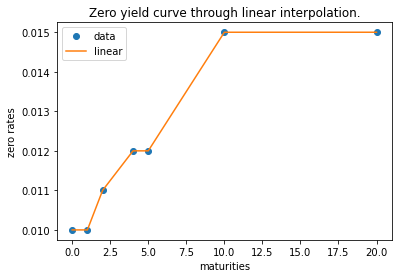

In [4]:
zero_yield_curve = interp1d(years1, zero_rates1)
xnew = np.linspace(0, 20, num=21, endpoint=True)
plt.title('Zero yield curve through linear interpolation.')
plt.xlabel('maturities')
plt.ylabel('zero rates')
plt.plot(years1, zero_rates1, 'o', xnew, zero_yield_curve(xnew))
plt.legend(['data', 'linear'], loc='best')
plt.show()

A vanilla IRS is made of a fixed and a floating leg.

The present value of a fixed rate leg is given by:
$$PV_{fixed}(t)=RN \sum^{n}_{i=1} \tau_i D_i$$
and the present value of a floating leg is given by:
$$PV_{float}(t)=N \sum^{n}_{i=1} (F_i +s) \tau_i D_i$$
where: 

$D_i=D(t,T_i)$ is the discount factor,

$s$ is the floating spread,

$N$ is the notional,

$\tau_i$ is $(T_i-T_{i-1})$, and

$R$ is the fixed rate.


In order the evaluate the present value of the fixed leg, we start by computing the discount factor $D_i=D(t,T_i)= e^{-(T_i-t)*zero \_ yield \_ curve(i)}$. We then use some known results and the unittest to check the code.

In [5]:
def discount_factor1(t, Ti, zero_yield_curve):
    return np.exp(-(Ti - t) * zero_yield_curve(Ti)) 


class TestDiscountFactor(unittest.TestCase):
    def test_discountfactor(self):
        self.assertAlmostEqual(discount_factor1(0, years1[1], zero_yield_curve), np.exp(-0.01))
        self.assertAlmostEqual(discount_factor1(0, years1[2], zero_yield_curve), np.exp(-0.022))


unittest.main(argv=[''], verbosity=2, exit=False)

test_discountfactor (__main__.TestDiscountFactor) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


Next we compute the forward rate $F_i=\frac{(\frac{D_{i-1}}{D_i}-1)}{\tau_i}$.

In [6]:
def forward_rates(
        t, time1, time2, zero_yield_curve):
    #time1 is the time used to evalaute D_{i-1} whilst time2 is used to evaluate D_i or viceversa
    if time1 == time2:
        tau = 0
    elif time1 > time2:
        tau = (time1 - time2)
    else:
        tau = (time2 - time1)
    y1 = discount_factor1(t, time1, zero_yield_curve)
    y2 = discount_factor1(t, time2, zero_yield_curve)
    if time1 == time2:
        forward_rate = zero_yield_curve(time1)
    elif time1 > time2:
        forward_rate = ((y2 / y1) - 1) / tau
    else:
        forward_rate = ((y1 / y2) - 1) / tau
    return forward_rate


class TestForwardRates(unittest.TestCase):
    def test_forwardrates(self):
        self.assertAlmostEqual(forward_rates(0, years1[2], years1[1], zero_yield_curve), np.exp(-0.01) / np.exp(-0.022) - 1)


unittest.main(argv=[''], verbosity=2, exit=False)


test_discountfactor (__main__.TestDiscountFactor) ... ok
test_forwardrates (__main__.TestForwardRates) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


We evaluate the present value of the fixed leg by using the formula we stated above. The variables in the formula below are:

$t:$ time at which the fixed leg is evaluated,

$coupon:$ coupon rate, frequency of payments in a year,

$end\_ date:$ maturity of the swap,

$k:$ fixed rate,

$n:$ notional.





In [7]:
def fixed_leg(t, coupon, end_date, k, n, zero_yield_curve):
    q = end_date * coupon #number of payments until end_date of the swap
    s = 0
    times = [0] * (q + 1)
    tau = 1 / coupon
    df = [0] * (q + 1)
    for i in range(1, q + 1):
        times[i] += (t + (1 / coupon) * i)
        df[i] += discount_factor1(t, times[i], zero_yield_curve)
        s += tau * df[i]
    return s * n * k

In [13]:
fixed_leg(0, 2, 5, 0.05, 100, zero_yield_curve)

24.22017670535429

We now evaluate the floating leg using the formula stated above. The variables used are the same as for the fixed leg.

In [14]:
def floating_leg(t, n, coupon, end_date, zero_yield_curve, forward_rates, spread):
    s1 = 0
    q = end_date *coupon
    times = [0] * (q + 1)
    tau = 1 / coupon
    y = [0] * (q + 1)
    z = [0] * (q + 1)
    for k in range(1, q + 1):
        times[k] += (t + (1 / coupon) * k)
        y[k] += discount_factor1(t, times[k], zero_yield_curve)
        z[k] += forward_rates(t, times[k - 1], times[k], zero_yield_curve)
        s1 += (z[k]+ spread) * tau * y[k]
    return n * s1

In [15]:
floating_leg(0, 100, 2, 5, zero_yield_curve, forward_rates,0.01)

10.667581982645967

The present value of IRS from the fixed rate receiver perspective = Present value of the fixed leg - Present value of the floating leg.

In [16]:
def IRS(coupon, end_date, n, t, zero_yield_curve, k,spread):
    return fixed_leg(t, coupon, end_date, k, n, zero_yield_curve) - floating_leg(t, n, coupon, end_date, zero_yield_curve, forward_rates,spread)


In [17]:
IRS(1, 5, 100, 0, zero_yield_curve, 0.05, 0.01)

13.493560275019371

The present value of an interest rate swap from the fixed rate payer perspective is equal to the present value of the floating leg - present value of the fixed leg.

In [19]:
def IRS1(coupon, end_date, n, t, zero_yield_curve, k,spread):
    return floating_leg(t, n, coupon, end_date, zero_yield_curve, forward_rates,spread)-fixed_leg(t, coupon, end_date, k, n, zero_yield_curve)

In [21]:
IRS1(2, 5, 100, 0, zero_yield_curve, 0.05, 0.01)

-13.552594722708324

We can now compute the Par swap rate, which is the value of the fixed rate that, at time $t$, makes the present value of the interest rate swap equal to $0$.
$$par\_ rate(t)=\frac{\sum^{n}_{i=1}(F_i +s)D_i \tau_i}{\sum^{n}_{i=1}D_i \tau_i}$$

In [22]:
def par_rate(coupon,end_date, t,zero_yield_curve, spread):
    q = coupon * end_date
    df = [0] * (q + 1)
    fr = [0] * (q + 1)
    times = [0] * (q + 1)
    tau = 1 / coupon
    s = 0
    k = 0
    for i in range(1, q + 1):
        times[i] = (t + (1 / coupon) * i)
        df[i] += discount_factor1(t, times[i], zero_yield_curve)
        fr[i] += forward_rates(t, times[i], times[i - 1], zero_yield_curve)
        s += (fr[i]+spread) * df[i] * tau
        k += df[i] * tau
    return s / k

In [23]:
par_rate(2, 5, 0, zero_yield_curve, 0.01)

0.02202209775845218

We can also compute the annuity $$A(t)=\sum^{n}_{i=1}D_i \tau_i$$

In [26]:
def annuity(coupon, end_date, t, zero_yield_curve):
    q = coupon * end_date
    df = [0] * (q + 1)
    times = [0] * (q + 1)
    tau = 1 / coupon
    s1 = 0
    for i in range(1, q + 1):
        times[i] = (t + (1 / coupon) * i)
        df[i] += discount_factor1(t, times[i], zero_yield_curve)
        s1 += df[i] * tau
    return s1


In [27]:
annuity(2, 5, 0, zero_yield_curve)

4.844035341070858

Then, the present value of the interest rate swap in terms of the annuity is given by:
    $$IRS(t)=notional*(fixed\_ rate - par\; swap\; rate(t))* A(t)$$
    $$=n*(k - par\; swap\; rate(t))*A(t)$$

In [28]:
def pv_swap(n, coupon, end_date, t, zero_yield_curve, k, par_rate,annuity,spread):
    a = par_rate(coupon, end_date, t, zero_yield_curve, spread)
    b = annuity(coupon, end_date, t, zero_yield_curve)
    return n * (k - a) * b

In [30]:

class TestIRS(unittest.TestCase):
    def test_IRS(self):
        self.assertAlmostEqual(pv_swap(100, 1, 5, 0, zero_yield_curve, 0.05, par_rate,ann,0.01), IRS(1, 5, 100, 0, zero_yield_curve, 0.05, 0.01))


unittest.main(argv=[''], verbosity=2, exit=False)


test_discountfactor (__main__.TestDiscountFactor) ... ok
test_forwardrates (__main__.TestForwardRates) ... ok
test_IRS (__main__.TestIRS) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.019s

OK


The present value of the interest rate calculated using the annuity agrees with the present value of the interest rate swap calculated using the fixed and the floating leg.

######################################################################################################################

We now want to price a CDS which is also made of two legs: 

The premium leg which can be calculated as follows:
$$R \sum^{b}_{i=a+1} P(0,T_i) \alpha_i Q(\tau \geq T_i)$$
and the floating leg which can be calculated as:
$$LGD \int^{T_b}_{T_a} P(0,t) d_t Q(\tau \geq t)$$

Our set of data in this case consists of: maturities $y$, hazard rates, $hazardrates$, and zero rates, $zerorates$, at each matuirty date.

In [31]:

y = [0, 1, 3, 5, 7, 10]
hazardrates = [0.03199, 0.03199, 0.03780, 0.04033, 0.04458, 0.03891]
zerorates = [0.01, 0.014, 0.011, 0.01, 0.001, 0.012]


We use the $hazardrates$ and $y$ to write a function for the hazard rate using constant interpolation.


In [32]:
def hazard_curve(x, years, hazard_rates):
    hz_rate = 0
    if years[0] <= x < years[1]:
        hz_rate += hazard_rates[1]
    elif years[1] <= x < years[2]:
        hz_rate += hazard_rates[2]
    elif years[2] <= x < years[3]:
        hz_rate += hazard_rates[3]
    elif years[3] <= x < years[4]:
        hz_rate += hazard_rates[4]
    else:
        hz_rate += hazard_rates[5]
    return hz_rate


class Testhazardratecurve(unittest.TestCase):
    def test_hzrates(self):
        self.assertAlmostEqual(hazard_curve(1.5, y, hazardrates), 0.0378)


unittest.main(argv=[''], verbosity=2, exit=False)

test_discountfactor (__main__.TestDiscountFactor) ... ok
test_forwardrates (__main__.TestForwardRates) ... ok
test_IRS (__main__.TestIRS) ... ok
test_hzrates (__main__.Testhazardratecurve) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.033s

OK


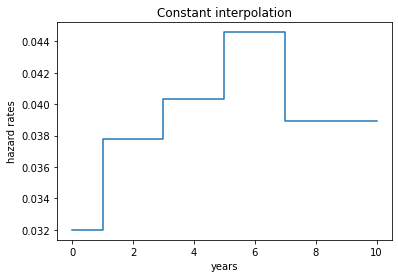

[0, 1, 3, 5, 7, 10]
[0.03199, 0.03199, 0.0378, 0.04033, 0.04458, 0.03891]


In [33]:
plt.title('Constant interpolation')
plt.xlabel('years')
plt.ylabel('hazard rates')
plt.step(y, hazardrates)
plt.show()
print(y)
print(hazardrates)


Next, we write a function to evaluate the survival probability $Q(\tau \geq t)$ and we check the results by using a unittest and the data in table 22.1 and 22.3 in Brigo Mercurio's book.

In [36]:
def survival_probability(t, years, hazard_rates, hazard_curve):
    y = np.linspace(0, t, 1000)
    d = 0
    for j in range(0, len(y)):
        if j == 0:
            d += 0
        else:
            d += (y[j] - y[j - 1]) * hazard_curve(y[j], years, hazard_rates)
    return np.exp(-d)
class Testsurvivalprob(unittest.TestCase):
    def test_survivalprob(self):
        self.assertAlmostEqual(survival_probability(y[1],y, hazardrates, hazard_curve), 0.968, places=2)


unittest.main(argv=[''], verbosity=2, exit=False)


test_discountfactor (__main__.TestDiscountFactor) ... ok
test_forwardrates (__main__.TestForwardRates) ... ok
test_IRS (__main__.TestIRS) ... ok
test_hzrates (__main__.Testhazardratecurve) ... ok
test_survivalprob (__main__.Testsurvivalprob) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.036s

OK


We use linear interpolation on $y$ and $zerorates$ to find the zero yield curve on this set of data.

In [37]:
zero_rate_curve = interp1d(y, zerorates)

We now write a function to compute $P(0,t).$

In [38]:
def curve(t, years, zero_rates, zero_rate_curve):
    z = np.linspace(0, t, 100)
    d1 = 0
    for j in range(0, len(z)):
        if j == 0:
            d1 += 0
        else:
            d1 += (z[j] - z[j - 1]) * zero_rate_curve(z[j])
    return np.exp(-d1)

Now, we write a function to compute the premium leg using the formula:
$$Premium\_ Leg(t)=\sum^{b}_{i=a+1}(R*Q(t\geq T_i)*P(0,T_i)*(T_i -T_{i-1}))$$

In [39]:
def prem_leg(t, end_date,coupon, k, zero_rates, hazard_rates, years):
    #end_date=maturity of the CDS
    s2 = 0
    q = (end_date-t) * coupon
    times = [0] * (q + 1)
    for i in range(1, q + 1):
        times[i] += (t + (1 / coupon) * i)
        s2 += (survival_probability(times[i], years, hazard_rates, hazard_curve)) * curve(times[i], years, zero_rates, zero_rate_curve) * (
                    times[i] - times[i - 1])
    return k * s2


In [40]:
prem_leg(0, 3, 2, 0.05, zerorates, hazardrates, y)

0.13824625674060737

The formula to compute the protection leg is:
$$LGD\sum^{n}_{i=a+1}\frac{1}{2} (Q(t \geq T_{i-1})-Q(\tau \geq T_i))*(P(0,T_{i-1})+ P(0,T_i))$$

In [41]:
def protect_leg(t, end_date,coupon, zero_rates, hazard_rates, years, LGD):
    q = (end_date-t) * coupon
    times = [0] * (q + 1)
    s4 = 0
    for i in range(1, (q + 1)):
        times[i] += (t + (1 / coupon) * i)
        s4 += (survival_probability(times[i - 1], years, hazard_rates, hazard_curve) - survival_probability(times[i], years, hazard_rates,
            hazard_curve)) * (curve(times[i - 1], years, zero_rates, zero_rate_curve) + curve(times[i], years, zero_rates, zero_rate_curve)) / 2
    return (LGD * s4)

In [42]:
protect_leg(0, 3, 2, zerorates, hazardrates, y, 0.6)

0.06007087663602395

Then the value of the CDS from the protection seller point of view= Premium leg - Protection leg.

In [43]:
def credit_default_swap(t, end_date, coupon, k, zero_rates, hazard_rates, years, LGD):
    return prem_leg(t, end_date, coupon, k, zero_rates, hazard_rates, years) - protect_leg(t, end_date, coupon, zero_rates, hazard_rates, years, LGD)
       

In [44]:
credit_default_swap(0, 3, 2, 0.05, zerorates, hazardrates, y, 0.6)


0.07817538010458341

Premium leg(t)= $R*Risky\_ Annuity(t)$ where the $$Risky\_ Annuity(t)=\frac{1}{2}(T_i -T_{1-i})*(P(0,T_i))*(Q(\tau \geq T_{i-1})+Q(\tau \geq T_i)$$

In [45]:
def risky_annuity(t,end_date,coupon,years,hazard_rates,zero_rates):
    q=(end_date-t)*coupon
    z=[0]*(q+1)
    summ=0
    for i in range(1,(q+1)):
        z[i]+=(t+(1/coupon)*i)
        summ+=(z[i]-z[i-1])*curve(z[i],years,zero_rates,zero_rate_curve)*(survival_probability(z[i-1],years,hazard_rates,hazard_curve)+survival_probability(z[i],years,hazard_rates,hazard_curve))
    return summ/2

In [46]:
risky_annuity(0, 3, 2, y, hazardrates, zerorates)

2.789877319427494

In [47]:
risky_annuity(0, 3, 2, y, hazardrates, zerorates) * 0.05

0.1394938659713747

$R*Risky\_ Annuity(t)= Premium\; Leg (t)$ is satisfied.

The par credit swap for a CDS is defined as $\frac{Protect\; leg(t)}{Annuity(t)}$. We can compute it and then check the result using the test data in Brigo-Mercurio's book (Interest Rate Models Theory and Practice (2001, Springer)) and unittest. Here we did not use bootstrapping instead we are using the hazard rates in the book to show that we get the same CDS spreads.

In [49]:
def par_credit_swap(t, end_date, coupon, zero_rates, hazard_rates, years, LGD):
    return protect_leg(t, end_date, coupon, zero_rates, hazard_rates, years, LGD) / risky_annuity(t, end_date, coupon, years, hazard_rates, zero_rates)
class Testparcreditswap(unittest.TestCase):
    def test_parcreditswap(self):
        self.assertAlmostEqual(par_credit_swap(0, 1, 2, zerorates, hazardrates, y, 0.6)
, 0.01925,places=5)
        self.assertAlmostEqual(par_credit_swap(0, 3, 2, zerorates, hazardrates, y, 0.6)
, 0.0215,places=4)
        self.assertAlmostEqual(par_credit_swap(0, 5, 2, zerorates, hazardrates, y, 0.6)
, 0.0225,places=4)
        self.assertAlmostEqual(par_credit_swap(0, 10, 2, zerorates, hazardrates, y, 0.6)
, 0.0235,places=3)
unittest.main(argv=[''], verbosity=2, exit=False)
       

test_discountfactor (__main__.TestDiscountFactor) ... ok
test_forwardrates (__main__.TestForwardRates) ... ok
test_IRS (__main__.TestIRS) ... ok
test_hzrates (__main__.Testhazardratecurve) ... ok
test_parcreditswap (__main__.Testparcreditswap) ... ok
test_survivalprob (__main__.Testsurvivalprob) ... ok

----------------------------------------------------------------------
Ran 6 tests in 1.653s

OK


#######################################################################################################################

Next, we want to price a CVA. From here on, no test data were available.

In the dissertation, we have mentioned that CVA can be expressed as sum of swaptions. Here, we are going to use this fact, by evaluating first the price of the nromal swaption both from the payer and receiver perspectives. 
Then we use those to price the CVA.

In [50]:
from scipy.stats import norm

$Price\; of\; normal\; swaption \; payer\; at\; time\; $0$ = notional* A(0) *\sigma *(T_0)^{1/2}(d_1*\Phi (d_1)+\Psi(d_1))$

$A(0)=\sum^{b}_{i=a}\tau_i P(0,T_i): annuity\; at\; time\; 0$,

$d_1=\frac{s(0)-K}{\sigma * (T_0)^{1/2}}$,

$s(0)=\frac{P(0,T_a)-P(0,T_b)}{A(0)}$,

$K: fixed\; rate,$

$T_0=T_a:$ maturity of the swaption,

$T_b:$ maturity of the swap.

In [51]:
def annuity_0(end_date, coupon, zero_rates, zero_rate_curve, initial_date, years):
    s5 = 0
    q = (end_date-initial_date) * coupon
    times = [0] * (q + 1)
    for k in range(1, (q + 1)):
        times[k] += initial_date + (1 / coupon) * k
        s5 += (times[k] - times[k - 1]) * curve(times[k], years, zero_rates, zero_rate_curve)
    return s5


In [52]:
annuity_0(8,1,zerorates,zero_rate_curve,5,y)

7.4834899241914785

In [55]:
def d1(strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years):
    return (rate(end_date, coupon, zero_rates, zero_rate_curve, initial_date, years) - strike) / (sigma * np.sqrt(
        initial_date))

In [56]:
d1(0.01, 0.2, 8, 2, zerorates, zero_rate_curve, 5, y)

-0.018555652292685694

In [57]:
def d2(strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years):
       return - d1(strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years)


In [58]:
d2(0.01, 0.2, 8, 2, zerorates, zero_rate_curve, 5, y)

0.018555652292685694

In [53]:
def rate(end_date, coupon, zero_rates, zero_rate_curve, initial_date, years):
    return (curve(initial_date, years, zero_rates, zero_rate_curve) - curve(end_date, years, zero_rates,
                                                                            zero_rate_curve)) / annuity_0(end_date,
                                                                                                          coupon,
                                                                                                          zero_rates,
                                                                                                          zero_rate_curve,
                                                                                                          initial_date,
                                                                                                          years)

In [54]:
rate(8, 1, zerorates, zero_rate_curve, 5, y)

0.0017057615388937476

Now, using the above functions we can evaluate the price of a normal swaption from the payer perspective:

In [60]:
def norm_swaption_payer(notional, strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years):
    d1_new = d1(strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years)
    return notional * annuity_0(end_date, coupon, zero_rates, zero_rate_curve, initial_date, years)*sigma * np.sqrt(
        initial_date) * (d1_new * norm.cdf(d1_new) + norm.pdf(d1_new))


In [95]:
norm_swaption_payer(100, 0.01, 0.2, 5, 1, zerorates, zero_rate_curve, 1, y)


38.199259693563135

and also the price of the normal swaption from the receiver perspective.

In [63]:
def norm_swaption_receiver(notional, strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years):
    d2_new = d2(strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years)
    return notional * sigma *annuity_0(end_date, coupon, zero_rates, zero_rate_curve, initial_date, years)* np.sqrt(
        initial_date) * (d2_new * norm.cdf(d2_new) + norm.pdf(d2_new))


In [105]:
norm_swaption_receiver(100, 0.01, 0.2, 5, 2, zerorates, zero_rate_curve,1 , y)


38.71510178790873

Then the CVA can be evaluated using the following formula:

$CVA=LGD*\sum^{b}_{i=a+1}(Q(t_{i-1})-Q(t_i))*Swaption\; Payer_t$, 

where the $swaption\; payer_t$ is the price of a normal swaption with expiry $t$.

In [67]:
def cva(LGD, notional, strike, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years, hazard_rates, hazard_curve):
    h = 0
    q = (end_date-initial_date) * coupon
    s=[0]*(q+1)
    m = [0] * (q + 1)
    for k in range(1, q + 1):
        m[k] += initial_date +int(1/coupon)* k
        s[k]+=norm_swaption_payer(notional, strike, sigma,m[k], coupon, zero_rates, zero_rate_curve,initial_date, years)
        h += (survival_probability(m[k-1], years, hazard_rates, hazard_curve)-survival_probability(m[k], years, hazard_rates, hazard_curve)) * s[k]
    return LGD * h

In [65]:
cva(0.6,100,0,0.02,8,1,zerorates,zero_rate_curve,5,y,hazardrates, hazard_curve)

1.7905355069242388

######################################################################################################################


Lastly, we are going to price Credit Insurance.

In Chapter 7, we found that the fair value of the price of Credit Insurance can be calculated as:
 $$CI= Premium\;Leg - Protection\;Leg$$
  $$=\sum^{b}_{i=a+1} \mathbb{E}[D(0, T_i) \cdot \alpha_i \cdot R ]-LGD \int_{t}^{T}\lambda_C(s) \cdot e^{-\int_{t}^{s}r_F(u)+\lambda_C(u) du}\mathbb{E}[min((1-p)V^+,K)]ds $$

$CI= premium \;leg - (CVA(with\; strike\; 0)-CVA(with\; strike\; K/(1-p))$

In [68]:
def prem_leg_CI(end_date, coupon, initial_date, k, zero_rates, years):
    s6 = 0
    q = (end_date-initial_date) * coupon
    times = [0] * (q + 1)
    for i in range(1, q + 1):
        times[i] += (initial_date + (1 / coupon) * i)
        s6 += (times[i] - times[i - 1]) * curve(times[i], years, zero_rates, zero_rate_curve)
    return k * s6

In [69]:
prem_leg_CI(8, 1, 5, 0.1, zerorates, y)

0.7483489924191479

In [70]:
def ci_swaption(LGD, notional, strike, p, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years,hazard_rates,hazard_curve):
    c = strike / (1 - p)
    return cva(LGD, notional, 0, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years,hazard_rates, hazard_curve) - cva(LGD,notional,c,sigma,end_date,coupon, zero_rates,zero_rate_curve,initial_date,years,hazard_rates,hazard_curve)


In [71]:
ci_swaption(0.6,100,0.1,0.3,0.02,8,1,zerorates,zero_rate_curve,5,y,hazardrates, hazard_curve)

1.7896205865019703

In [72]:
def ci(LGD, notional, strike, p, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years, k,hazard_rates,hazard_curve):
    return prem_leg_CI(end_date, coupon, initial_date, k, zero_rates, years) - ci_swaption(LGD, notional, strike, p, sigma, end_date, coupon, zero_rates, zero_rate_curve, initial_date, years,hazard_rates,hazard_curve)
        

In [73]:
ci(0.6,100,0.1,0.4,0.007,8,1,zerorates,zero_rate_curve,5,y,0.1,hazardrates,hazard_curve)

0.0766775218579181